# Exemple d'utilisation de OCLI
Pour accéder aux données GLS (Global Land Service) on fait appel à l'objet `Ocli`.
Les mêmes codes peuvent être utilisés pour différents indicateurs GLS : FCOVER, FAI, FAPAR, NLVI.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdt
from matplotlib.patches import Rectangle
%matplotlib inline

plt.rcParams["figure.figsize"] = (9,6)

import esg_deforestation_radar as sentinel

In [2]:
%reload_ext autoreload
%autoreload 2

## Etude d'une zone géographique.
Un fichier JSON 'geozone.json' est stocké dans un répertoire de données temporaire.
Ce répertoire sert de cache, les données sources issues de Sentinel Hub se trouve dans un autre répertoire. En général ce second répertoire est un disque serveur de grande capacité.

Pour cet exemple on va suivre l'indicateur FCOVER qui représente la couverture végétale d'une zone. Le champ FCOVER du dictionnaire JSON contient l'adresse du répertoire où sont stockés les données sources. Ici il s'agit essentiellement de répertoires qui contiennent des fichiers netCDF.

Le répertoire temporaire sera nommé 'target' et rajouté au dictionnaire issu du JSON.

In [3]:
# Sélection d'une zone géographique.
target = '../data/Barro-Alto'
zone = sentinel.getzone(target)
zone

{'name': 'Barro Alto - Nickel (Brasil)',
 'bbox': [-15.12, -49.06, -15.02, -48.92],
 'step': 10,
 'GRD': '/Volumes/JLTD/Sentinel/GRD/Barro-Alto',
 'FCOVER': '/Volumes/JLTD/Sentinel/FCOVER',
 'NDVI': '/Volumes/JLTD/Sentinel/NDVI',
 'target': '../data/Barro-Alto',
 'LAI': '/Volumes/JLTD/Sentinel/LAI',
 'TCI': '/Volumes/JLTD/Sentinel/TCI'}

In [4]:
# Récupération d'un pointeur sur la zone image.
indice = 'FCOVER'
geo = sentinel.Ocli(zone,indice)

In [5]:
# Elargissement dans le cas de la température.
# Effectué dans ocli.get_ncmean().abs

#if indice == 'TCI':
#    lat0,lon0,lat1,lon1 = zone['bbox']
#    lat = (lat0 + lat1)/2.0
#    lon = (lon0 + lon1)/2.0
#    zone['bbox'] = [lat-5.0, lon-5.0, lat+5.0, lon+5.0]

In [6]:
# La liste des données récupérées avec leurs révisions.
geo.datalist.tail(10)

,FILE,REVISION
DATE,,
2021-02-28,/Volumes/JLTD/Sentinel/FCOVER/C0102487/FCOVER3...,6
2021-03-10,/Volumes/JLTD/Sentinel/FCOVER/C0102487/FCOVER3...,6
2021-03-20,/Volumes/JLTD/Sentinel/FCOVER/C0102487/FCOVER3...,6
2021-03-31,/Volumes/JLTD/Sentinel/FCOVER/C0102487/FCOVER3...,6
2021-04-10,/Volumes/JLTD/Sentinel/FCOVER/C0102487/FCOVER3...,2
2021-04-20,/Volumes/JLTD/Sentinel/FCOVER/C0102487/FCOVER3...,2
2021-04-30,/Volumes/JLTD/Sentinel/FCOVER/C0102487/FCOVER3...,2
2021-05-10,/Volumes/JLTD/Sentinel/FCOVER/C0102487/FCOVER3...,2
2021-05-20,/Volumes/JLTD/Sentinel/FCOVER/C0102487/FCOVER3...,1


In [7]:
geo.datalist.head(5)

,FILE,REVISION
DATE,,
2016-01-10,/Volumes/JLTD/Sentinel/FCOVER/C0093628/FCOVER3...,9
2016-01-20,/Volumes/JLTD/Sentinel/FCOVER/C0093628/FCOVER3...,9
2016-01-31,/Volumes/JLTD/Sentinel/FCOVER/C0093628/FCOVER3...,9
2016-02-10,/Volumes/JLTD/Sentinel/FCOVER/C0093628/FCOVER3...,9
2016-02-20,/Volumes/JLTD/Sentinel/FCOVER/C0093628/FCOVER3...,9


In [8]:
# On charge la troisième image de la liste.
geo[3]

In [9]:
# Récupération des dates : la première de la liste, celle qui est chargée, la dernière.
geo.datemin, geo.date, geo.datemax

(datetime.date(2016, 1, 10),
 datetime.date(2016, 2, 10),
 datetime.date(2021, 5, 31))

In [10]:
# On charge la dernière image avant la date spécifiée.
geo.load('2020-11-01')
# On renvoie sa position dans la liste, sa date et sa révision.
geo.pos,str(geo.date),geo.rev

(163, '2020-10-31', 6)

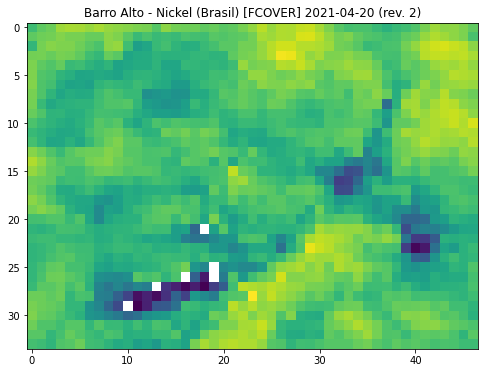

In [11]:
# On affiche une image chargée. L'indexation fonctione correctement.
geo[-5].plot()

In [12]:
# Pour visualiser successivement des images, il suffit de programmer une petite interactivité.
import ipywidgets as widgets

def glsimage(i):
    geo[i].plot()
    
widgets.interact(glsimage, i=widgets.IntSlider(min=0, max=len(geo)-1, step=1, value=18));

interactive(children=(IntSlider(value=18, description='i', max=184), Output()), _dom_classes=('widget-interact…

On affiche les statistiques par la méthode `mean()`, or récupère l'indicateur (ici FCOVER) l'erreur RMSE et la proportion de cellules de 300 $m^2$ renseignées.

Attention le résultat n'est pas forcément égal à celui capitalisé dans le résumé (voir plus bas), ce dernier appliquant une forme de correction par lissage des valeurs manquantes.

In [13]:
# Affichage de l moyenne, l'écart-type et le taux de remplissage.
geo.mean()

(0.3667134271843711, 0.03118398282047506, 1.0)

## OCLI résumé

Les indicateurs sont sauvegardés dans des fichiers CSV dont le nom commence par celui de l'indicateur suivi de 'table.csv'. Quand ils sont prés calculés, il est possible d'y accéder rapidement depuis le package `dataset`.

On retrouve le nom du fichier, la révision, l'indicateur, l'erreur et le taux de cellules non manquantes.

In [14]:
F = sentinel.dataset.gls(zone,indice)
F

,FILE,REVISION,FCOVER,RMSE,PR
DATE,,,,,
2016-01-10,/Volumes/JLTD/Sentinel/FCOVER/C0093628/FCOVER3...,9,0.808591,0.124193,0.821652
2016-01-20,/Volumes/JLTD/Sentinel/FCOVER/C0093628/FCOVER3...,9,0.799199,0.032586,1.000000
2016-01-31,/Volumes/JLTD/Sentinel/FCOVER/C0093628/FCOVER3...,9,0.806481,0.033995,1.000000
2016-02-10,/Volumes/JLTD/Sentinel/FCOVER/C0093628/FCOVER3...,9,0.811652,0.034934,0.998123
2016-02-20,/Volumes/JLTD/Sentinel/FCOVER/C0093628/FCOVER3...,9,0.812406,0.036070,0.999374
...,...,...,...,...,...
2021-04-20,/Volumes/JLTD/Sentinel/FCOVER/C0102487/FCOVER3...,2,0.697274,0.098816,0.996245
2021-04-30,/Volumes/JLTD/Sentinel/FCOVER/C0102487/FCOVER3...,2,0.671417,0.099825,0.995620
2021-05-10,/Volumes/JLTD/Sentinel/FCOVER/C0102487/FCOVER3...,2,0.630641,0.103970,0.990613


<AxesSubplot:xlabel='DATE'>

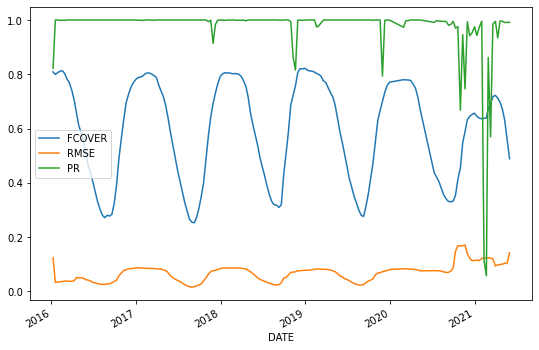

In [15]:
F[[indice,'RMSE','PR']].plot()

Ces calculs peuvent être relancés à l'aide de la commande `glscompute()`.

En fait comme les données ne sont pas systématiquement renseignées à cause de la météorologie, deux traitements supplémentaires ont été fait en plus du calcul de l'indicateur moyen :

* Les données manquantes sont par défaut fixées à la médiane des observations, l'erreur augmente par contre en conséquence.
* La lectutre progressive au fil du temps permet de rempacer une valeur manquante par la valeur précédente observée de la même cellule. On a donc un effet de lissage supplémentaire, mais l'erreur prend en compte ce remplacement.

Ce calcul progressif empêche la réunilisation des données précédentes sans un stockage des images.

In [16]:
sentinel.glscompute(zone, indice)

Barro-Alto:   0%|          | 0/185 [00:00<?, ?it/s]

Il est possible d'afficher la courbe avec des tubes d'erreurs à ± un écart-type.

* La courbe verte utilise l'écart-type sur les cellules compensé par une valeur moyenne des écart-types sur les valeurs manquantes.
* La courbe rouge force les valeurs manquantes à aveoir un écart-type de 0.5 et donc met en évidence le taux de remplissage de l'image optique.

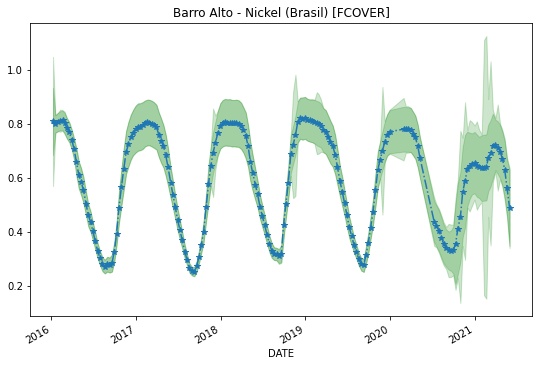

In [17]:
# Affichage de la courbe et des deux tubes d'erreurs.
sentinel.dataset.glsplot(zone,indice)

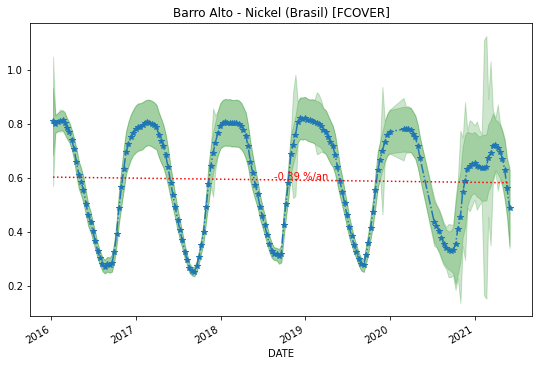

In [18]:
# L'option `reg=True` permet d'afficher une droite de régression.
sentinel.dataset.glsplot(zone,indice, reg=True)

_Jérôme Lacaille_